In [1]:
from __future__ import print_function
import tensorflow as tf
import keras
import pickle
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model 
from tensorflow.keras.applications.vgg16 import VGG16
import numpy as np
import os
from sklearn.model_selection import train_test_split


Using TensorFlow backend.


In [2]:
def lr_schedule(epoch):
    
    lr = 1e-3 #1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 80:
        lr *= 1e-3
    elif epoch > 40: # 120
        lr *= 1e-2
    elif epoch > 30: #80
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [3]:
# Training parameters
batch_size = 16
epochs = 50
num_classes = 2

In [4]:
#pickle_in = open("X.pickle","rb")
pickle_in = open("/home/trojan/Desktop/dimentia/CNN_simple/kfold/X.pickle","rb")
X = pickle.load(pickle_in)

#pickle_in = open("y.pickle","rb")
pickle_in = open("/home/trojan/Desktop/dimentia/CNN_simple/kfold/y.pickle","rb")
y = pickle.load(pickle_in)

In [5]:
X = np.array(X)
y = np.array(y)

In [6]:
X.shape

(19677, 256, 256, 3)

In [7]:
y.shape

(19677,)

In [8]:
input_shape = X.shape[1:]

In [9]:
print(input_shape)

(256, 256, 3)


In [10]:
x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  shuffle=True, stratify=y, 
                                                  test_size=0.2, random_state=42)

In [11]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

In [12]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')
print('y_train shape:', y_train.shape)

x_train shape: (15741, 256, 256, 3)
15741 train samples
3936 validation samples
y_train shape: (15741, 2)


In [20]:
initializer = 'he_normal'
model = Sequential()

model.add(VGG16(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=input_shape,
    pooling=None,
    classes=2,
    classifier_activation="softmax",
))



In [21]:
model.compile(optimizer=Adam(lr=lr_schedule(0)),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
model.summary()

Learning rate:  0.001
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2)                 165726018 
Total params: 165,726,018
Trainable params: 165,726,018
Non-trainable params: 0
_________________________________________________________________


In [22]:
'''model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr_schedule(0)),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )
model.summary()'''

'model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr_schedule(0)),\n        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),\n        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]\n    )\nmodel.summary()'

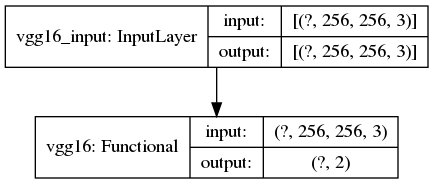

In [23]:
tf.keras.utils.plot_model(model, to_file='my_model.png', show_shapes=True)

In [24]:
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
#es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=7)

lr_scheduler = LearningRateScheduler(lr_schedule)

callbacks = [checkpoint, lr_scheduler] # [checkpoint, lr_reducer, lr_scheduler]

In [ ]:
model.fit(x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=callbacks)

Learning rate:  0.001
Epoch 1/50
984/984 [==============================] - ETA: 0s - loss: 0.6948 - accuracy: 0.5005WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0055s vs `on_test_batch_end` time: 0.0411s). Check your callbacks.

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to best_model.h5
984/984 [==============================] - 279s 283ms/step - loss: 0.6948 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.5000
Learning rate:  0.001
Epoch 2/50
271/984 [=======>......................] - ETA: 1:51 - loss: 0.6932 - accuracy: 0.5069

In [ ]:
model = load_model('best_model.h5')

In [ ]:
# Score trained model.
scores = model.evaluate(x_val, y_val, verbose=1)
print('Val loss:', scores[0])
print('Val accuracy:', scores[1])